In [8]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns
tf.enable_v2_behavior()
import numpy as np
import lanczos_algorithm

In [9]:
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


synthetic = False

if synthetic:
    num_samples = 1000
    num_features = 70
    num_informative = 10



    x, y, coef = datasets.make_regression(n_samples=num_samples,      #number of samples
                                          n_features=num_features,    #number of features
                                          n_informative=num_informative, #number of useful features 
                                          noise=5,                   #bias and standard deviation of the guassian noise
                                          coef=True,                  #true coefficient used to generated the data
                                          random_state=0)             #set for same data points for each run

    XX = np.interp(x, (x.min(), x.max()), (0, 20))
    yy = np.interp(y, (y.min(), y.max()), (0, 20))
    
    # Split the data into training/testing sets
    X = XX[:-100]
    X_test = XX[-100:]

    # Split the targets into training/testing sets
    y = yy[:-100]
    y_test = yy[-100:]
    
    num_samples = 900

#     print(x.shape)
#     print(y.shape)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.view_init(-155, -20)
#     ax.scatter(X[:,0],X[:,1],y)
#     plt.show()
#     plt.ion() #interactive plot on
#     plt.plot(x,y,'.',label='training data')
#     plt.xlabel('x');plt.ylabel('y')
    
    
    
# else:
    
#     dataset = "lympho"

#     # The original lymphography dataset from UCI machine learning repository is a 
#     # classification dataset. It is a multi-class dataset having four classes, but
#     # two of them are quite small (2 and 4 data records). Therefore, those two small 
#     # classes are merged and considered as outliers compared to other two large 
#     # classes (81 and 61 data records).
#     if dataset == "lympho":  
#         matA = scipy.io.loadmat('lympho.mat')     
        
#     if dataset == "satellite":
#         matA = scipy.io.loadmat('satellite.mat')
    
#     # The original MNIST dataset of handwritten digits has a training set of 60,000 examples, 
#     # and a test set of 10,000 examples. It is a subset of a larger set available from MNIST. 
#     # The digits have been size-normalized and centered in a fixed-size image. This dataset 
#     # is converted for outlier detection as digit-zero class is considered as inliers, while 
#     # 700 images are sampled from digit-six class as the outliers. In addition, 100 features 
#     # are randomly selected from 784 total features.
    
#     if dataset == "mnist":
#         matA = scipy.io.loadmat('mnist.mat')
#     print(matA)
#     X, y = matA['X'], matA['y']
#     y= y.flatten()
#     print(X.shape) 
#     print(y)
#     num_samples = X.shape[0]
#     num_features = y.shape[0]



else:
    #diabetes dataset

    # Load the diabetes dataset
    diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
    diabetes_y= diabetes_y.flatten()


    # Split the data into training/testing sets
    X = diabetes_X[:-20]
    X_test = diabetes_X[-20:]

    # Split the targets into training/testing sets
    y = diabetes_y[:-20]
    y_test = diabetes_y[-20:]
    print(diabetes_X.shape, diabetes_y.shape)
    num_samples = X.shape[0]
    num_features = y.shape[0]


(442, 10) (442,)


In [10]:
class GradientDescentLinearRegression:
    def __init__(self, learning_rate=1e-5, iterations=10000):
        
        self.__lr, self.itr = learning_rate, iterations
    
    def fit(self, X, y):
        n,d = X.shape[0],X.shape[1]
        self.b = 0
        self.w = np.zeros(d)
        self.w.fill(2)

        for _ in range(self.itr):
            
#             print(X.shape,self.w.shape)
            h = X@self.w + self.b
            dw =  X.T@ (h-y)  / n
            db = np.sum(h-y)  / n
            self.w = self.w - self.__lr*dw
            self.b = self.b - self.__lr*db
        
    def predict(self, X):
        return X@self.w + self.b
    

clf = GradientDescentLinearRegression()
# print(X.shape)
# print(y.shape)
clf.fit(X, y)

# import matplotlib.pyplot as plt

# fig = plt.figure()

# ax = fig.add_subplot(111, projection='3d')

# minX = min(np.min(X[:,0]), np.min(X[:,1]))
# maxX = min(np.max(X[:,0]), np.max(X[:,1]))


# tmp = np.linspace(minX,maxX,50)
# x1, x2 = np.meshgrid(tmp,tmp)
# x1=x1.flatten()
# x2=x2.flatten()
# print(x1[0],x2[0])
# print(x1.shape,x2.shape)
# y_pred = []
# for i in range(x1.shape[0]):
#     y_pred.append(clf.predict([x1[i],x2[i]]))
# y_pred = np.array(y_pred)
# print(y_pred.shape)
# print(X[:,0].shape,X[:,1].shape,y.shape)

# ax.scatter(X[:,0],X[:,1],y,color='g')
# ax.scatter(x1,x2, y_pred, alpha = 0.05,color='r')
# ax.view_init(-155, -20)
# plt.show()


[3.83300492 1.39206685 1.15683427 0.00838791 0.07437445 0.91765477
 0.41723865 0.63698206 0.57694132 0.52087889]


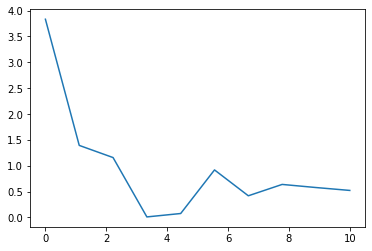

In [11]:
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh

H = X.T@X
# print(H)

w,v = np.linalg.eig(H)
# print(v*w@v.T-H)
print(w)
H_til=H/w[0]

num_eigen = np.linspace(0,len(w),len(w))
plt.plot(num_eigen,w)


1.4874385227151845


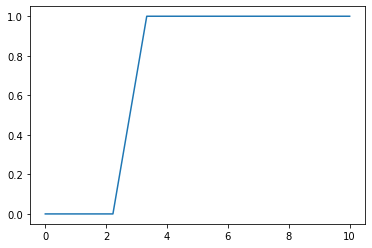

In [12]:
#low pass filter
w_til, v_til= np.linalg.eig(H_til)
# print(w_til)
energysum = np.sum(w_til[1:])
print(energysum)
for i in range(len(w_til)):
    if w_til[i]>energysum*0.2:
        w_til[i]= 0
    else:
        w_til[i]= 1
plt.plot(num_eigen,w_til)

In [13]:
import math

def compute_moments(A, v, deg):
    Amv = np.zeros((len(v), deg+1))
    for i in range(deg+1):
        if i == 0:
            Amv[:, i] = v
        else:
            Amv[:, i] = np.dot(A, Amv[:, i-1])

    return np.dot(v, Amv)


def compute_Chebyshev_moments(x):
    deg = len(x)
    Tk = np.zeros(deg)
    for k in range(deg):
        if k == 0:
            Tk[k] = 1
        elif k == 1:
            Tk[k] = x[k]
        else:
            for j in range(int(np.floor(k/2))+1):
                akj = (comb(2*j, j)*comb(k, 2*j)) / comb(k-1, j)
                Tk[k] = Tk[k] +\
                    ((-1)**j)*((2**(k-2*j-1))*(akj*x[k-2*j]))
    return Tk


def Chebyshev_step(deg, eps, damp):
    alpha1 = eps
    alpha2 = 1
    thetJ = math.pi/(deg+2)
    thetL = math.pi/(deg+1)
    a1 = 1/(deg+2)
    a2 = math.sin(thetJ)
    beta1 = math.acos(alpha1)
    beta2 = math.acos(alpha2)
    mu = np.zeros(deg+1)
    for k in range(deg+1):
        if damp == 0:
            jac = 1
        elif damp == 1:
            jac = a1*math.sin((k+1)*thetJ)/a2 + \
                (1-(k+1)*a1)*math.cos(k*thetJ)
        elif damp == 2:
            jac = 1
            if (k > 0):
                jac = math.sin(k*thetL)/(k*thetL)

        if k == 0:
            mu[k] = -jac*(beta2-beta1)/math.pi
        else:
            mu[k] = -2*jac*(
                math.sin(k*beta2)-math.sin(k*beta1))/(math.pi*k)

    return mu

# a = Chebyshev_step(3, 0.1, 1)
# print(a)

In [14]:
from scipy.special import comb
from numpy import linalg as LA

S_H = v_til*w_til@v_til.T
# print(X.shape)

influence_x_H_inv = []
influence_x_SH = []
influence_x_Cheb = []


deg = 15
damp = 2
eps = 0.001
for i in range(num_samples):
    xi = []
    for j in range(X.shape[1]):
        xi.append(X[i][j])
    xi = np.array(xi)
    h = clf.predict(xi)
#     print(h)
    dli = -(y[i]-h)*xi
#     print(dli.shape,S_H.shape)

    #chebyshev step
    mom = compute_moments(S_H, dli, deg)
    cheb_mom = compute_Chebyshev_moments(mom)
    mu = Chebyshev_step(deg, eps, damp)
    approx = mu@cheb_mom

    influence_x_Cheb.append(approx)
    influence_x_H_inv.append(dli@np.linalg.inv(H)@dli)
    influence_x_SH.append(dli@S_H@dli)
    
# print(influence_x_H_inv/np.sum(influence_x_H_inv))
# print(influence_x_SH/np.sum(influence_x_SH))
x_axis = np.linspace(0,num_samples,num_samples)


p_H_inv = influence_x_H_inv/np.sum(influence_x_H_inv)
p_S_H = influence_x_SH/np.sum(influence_x_SH)
p_Cheb_H = influence_x_Cheb/np.sum(influence_x_Cheb)

ind_Hinv = np.argsort(p_H_inv)[::-1]
ind_S_H = np.argsort(p_S_H)[::-1]
ind_Cheb_H = np.argsort(p_Cheb_H)[::-1]

subsamp_per = 0.2
subsamp_num = int(num_samples*subsamp_per)
ind_Hinv_sub =  ind_Hinv[:subsamp_num]
ind_S_H_sub =  ind_S_H[:subsamp_num]
ind_Cheb_H_sub = ind_Cheb_H[:subsamp_num]


ind_Hinv_sub_s =  ind_Hinv[subsamp_num:]
ind_S_H_sub_s =  ind_S_H[subsamp_num:]
ind_Cheb_H_sub_s = ind_Cheb_H[subsamp_num:]




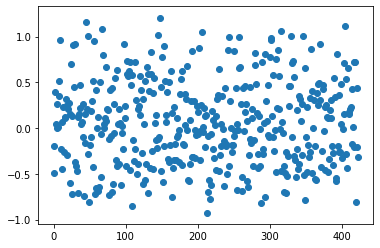

71 / 97
0.7319587628865979


In [17]:
relative_pi = []
for i in range(len(x_axis)):
    relative_pi.append((p_S_H[i]-p_H_inv[i])/p_H_inv[i])
# plt.plot(x_axis, p_H_inv, label="h_inv")
# plt.plot(x_axis, p_S_H,c='r', label="S(H)")
# plt.legend()
plt.scatter(x_axis,relative_pi, label='relative pi')
plt.show()

print(len(np.intersect1d(ind_Hinv_sub,ind_S_H_sub)),'/',len(np.union1d(ind_Hinv_sub,ind_S_H_sub)))
print(len(np.intersect1d(ind_Hinv_sub,ind_S_H_sub))/len(np.union1d(ind_Hinv_sub,ind_S_H_sub)))



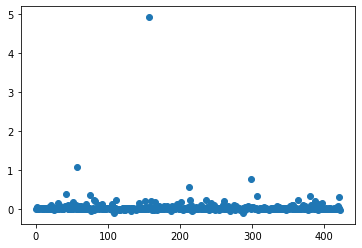

84 / 84
1.0


In [18]:
relative_pi = []
for i in range(len(x_axis)):
    relative_pi.append((p_Cheb_H[i]-p_S_H[i])/p_S_H[i])
    
# plt.plot(x_axis, p_S_H,c='r', label="S(H)")
# plt.plot(x_axis, p_Cheb_H,c = 'g', label="P_cheb(H)")
# plt.legend()
plt.scatter(x_axis,relative_pi, label='relative pi')
plt.show()

print(len(np.intersect1d(ind_Cheb_H_sub,ind_S_H_sub)),'/',len(np.union1d(ind_Cheb_H_sub,ind_S_H_sub)))
print(len(np.intersect1d(ind_Cheb_H_sub,ind_S_H_sub))/len(np.union1d(ind_Cheb_H_sub,ind_S_H_sub)))




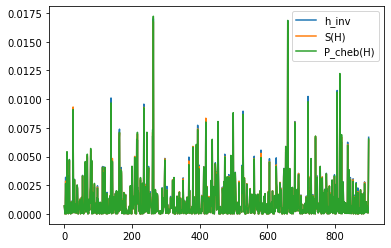

In [388]:

plt.plot(x_axis, p_H_inv, label="h_inv")
plt.plot(x_axis, p_S_H, label="S(H)")
plt.plot(x_axis, p_Cheb_H, label="P_cheb(H)")
plt.legend()
plt.show()



In [389]:
y_pred = clf.predict(X_test)

clf_Hinv = GradientDescentLinearRegression()
clf_SH = GradientDescentLinearRegression()
clf_PH = GradientDescentLinearRegression()

clf_Hinv.fit(X[ind_Hinv_sub_s],y[ind_Hinv_sub_s])
clf_SH.fit(X[ind_S_H_sub_s],y[ind_S_H_sub_s])
clf_PH.fit(X[ind_Cheb_H_sub_s],y[ind_Cheb_H_sub_s])


y_pred_Hinv = clf_Hinv.predict(X_test)
y_pred_SH = clf_SH.predict(X_test)
y_pred_PH = clf_PH.predict(X_test)

# The mean squared error
print('---full---Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('---Hinv---Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_Hinv))
print('---SH---Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_SH))
print('---PH---Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_PH))

# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f'
#       % r2_score(diabetes_y_test, diabetes_y_pred))


---full---Mean squared error: 4.04
---Hinv---Mean squared error: 6.48
---SH---Mean squared error: 6.52
---PH---Mean squared error: 6.53


In [ ]:
import jax.density as density_lib

def plot(grids, density, label=None):
  plt.semilogy(grids, density, label=label)
  plt.ylim(1e-10, 1e2)
  plt.ylabel("Density")
  plt.xlabel("Eigenvalue")
  plt.legend()

density, grids = density_lib.tridiag_to_density(
    [T.numpy()], grid_len=10000, sigma_squared=1e-3)

plot(grids, density)